In [87]:
%cd /data/nijhawanlab/amplicons/VK008/
R1_file = "VK008_R1_001.fastq.gz"
R2_file = "VK008_R2_001.fastq.gz"
primer_file = "primers.txt"
samples_file = "VK008_samples.csv"
experiment = "VK008"

/data/nijhawanlab/amplicons/VK008


In [3]:
! md5sum --check md5sum_list.txt

./VK008_R2_001.fastq.gz: OK
./VK008_R1_001.fastq.gz: OK


In [4]:
! seqkit stats *.fastq.gz

file                   format  type  num_seqs     sum_len  min_len  avg_len  max_len
VK008_R1_001.fastq.gz  FASTQ   DNA    446,056  82,511,046       35      185      250
VK008_R2_001.fastq.gz  FASTQ   DNA    446,056  82,776,533       35    185.6      250


In [5]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' # TTCTTGACGAGTTCTTCTGA
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' # ACGCGTCTGGAACAATCAAC
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'

In [6]:
# This works to make output cell wide, with a horiztonal scroll bar.
# https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
# change the cell width
# This doesn't scroll, just makes the cells wide.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
# import xlwt, openpyxl
import colored

In [9]:
pd.__version__

'1.0.3'

In [10]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [11]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [12]:
from colored import fg, bg, attr
from itertools import cycle

def colorIntervals(seq, intervals, 
                   default_color = bg('black')+fg('white'), 
                   color_list = [bg('grey_50')+fg('black'), bg('grey_85')+fg('white'), bg('grey_50')+fg('black'), bg('orange_red_1'), bg('dark_blue')], 
                   offset=0):
    color = cycle(color_list)
    intervals.sort()
    if any(intervals[i+1][0]-intervals[i][1] <=0 for i in range(len(intervals)-1)):
        print("ColorSeq: Intervals cannot overlap.")
        return seq
    colored_string = default_color + offset*' ' # seq[:intervals[0][0]]
    last_index = 0 # intervals[0][1]
    for interval in intervals:
        colored_string += seq[last_index:interval[0]]
        c = next(color)
        colored_string += c + seq[interval[0]:interval[1]] + default_color
        last_index = interval[1]
    colored_string += seq[last_index:] + bg(0) + fg(0) + attr('reset')
    return colored_string

## Read Input Files

### Read in primers.txt and store primers in various useful forms

In [14]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(primers_IO, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [15]:
forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [16]:
primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

In [17]:
primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

### Load paired reads from FASTQ files

In [18]:
R1 = gzip.open(R1_file, "rt")
R2 = gzip.open(R2_file, "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
maxReads = 500000
readNumber = 0
reads_list = []
for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)
    
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    
    full_read = {}
    full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
    full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
    full_read.update({
        'R1_sequence':R1_sequence,
        'R2_sequence':R2_sequence
    })

    if(not None in full_read.values() ):       
        reads_list.append(full_read)
    # print(full_read)
    readNumber += 1
    if readNumber > maxReads:
        break

print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber-1))
reads_table = pd.DataFrame(reads_list)
        
R1.close()
R2.close()

maxReads: 500000
Total reads: 446055


### Define calculated columns in the reads_table

In [19]:
reads_table['forward_primer']=reads_table['R1_fwd_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_rc_primer'])
reads_table['reverse_primer']=reads_table['R1_rc_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_fwd_primer'])
reads_table['sequence']=reads_table['R1_sequence'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R2_sequence'])

In [20]:
reads_table['R1_pre_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R1_post_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))

)
reads_table['R2_pre_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R2_post_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))
)

In [21]:
reads_table['R1_barcode_loc']=reads_table.apply(
    lambda row: [row['R1_pre_loc']+len(reference_sequence_pre), row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: [row['R1_post_loc']+len(reference_sequence_post), row['R1_pre_loc']] , axis=1)
)

reads_table['R2_barcode_loc']=reads_table.apply(
    lambda row: [row['R2_pre_loc']+len(reference_sequence_pre), row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: [row['R2_post_loc']+len(reference_sequence_post), row['R2_pre_loc']], axis=1)
)

reads_table['R1_barcode']=reads_table.apply(
    lambda row: row['R1_sequence'][row['R1_pre_loc']+len(reference_sequence_pre):row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: rcDNA( row['R1_sequence'][row['R1_post_loc']+len(reference_sequence_post):row['R1_pre_loc']] ), axis=1)
)

reads_table['R2_barcode']=reads_table.apply(
    lambda row: row['R2_sequence'][row['R2_pre_loc']+len(reference_sequence_pre):row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: rcDNA( row['R2_sequence'][row['R2_post_loc']+len(reference_sequence_post):row['R2_pre_loc']] ), axis=1)
)

### Filtering

Column `sanity` accumulates all our checks on the correctness of the reads.  Start by checking that the primers for the forward and reverse reads are the same, and that the inferred directionality matches.

In [22]:
reads_table['sanity'] = (
    (reads_table['R1_fwd_primer'] == reads_table['R2_rc_primer']) &
    (reads_table['R1_rc_primer'] == reads_table['R2_fwd_primer']) &
    (reads_table['R1_fwd_direction'] == reads_table['R2_rc_direction']) &
    (reads_table['R1_rc_direction'] == reads_table['R2_fwd_direction']) &
    (reads_table['R1_fwd_direction'] != reads_table['R1_rc_direction']) 
)

Now check that the barcodes in both paired reads match each other and match the defined pattern.

In [23]:
barcode_regex = re.compile('([GC][AT])+')

def checkBarcodePattern(b):
    if barcode_regex.fullmatch(b):
        return True
    else:
        return False

reads_table['sanity'] = (
    reads_table['sanity'] & 
    (reads_table['R1_barcode']==reads_table['R2_barcode'])
)

reads_table['barcode_length']=reads_table['R1_barcode'].apply( len )

In [24]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK048,0,oVK037,157,R,F,oVK037,0,oVK048,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTGTGTCACTGTCTCTGACAGA,GTGTGTGTCACTGTCTCTGACAGA,True,24
1,oVK026,0,oVK025,157,R,F,oVK025,0,oVK026,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTCTCTGTCTCAGTGAGACACT,GTGTCTCTGTCTCAGTGAGACACT,True,24
2,oVK043,0,oVK033,157,R,F,oVK033,0,oVK043,155,...,59,15,106,150,"[35, 59]","[126, 150]",GACTGTGTCAGTGAGAGTGACTCT,GACTGTGTCAGTGAGAGTGACTCT,True,24
3,oVK048,0,oVK033,157,R,F,oVK033,0,oVK048,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCAGTGAGACTCTCTCAGAGTGT,GTCAGTGAGACTCTCTCAGAGTGT,True,24
4,oVK031,0,oVK040,155,F,R,oVK040,0,oVK031,157,...,106,150,59,15,"[126, 150]","[35, 59]",GTCACTGTGTGTCTGACTCTGAGT,GTCACTGTGTGTCTGACTCTGAGT,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242631,oVK025,0,oVK043,149,F,R,oVK043,0,oVK025,151,...,106,144,53,15,"[126, 144]","[35, 53]",CTGAGTGTCAGTCACTCT,CTGAGTGTCAGTCACTCT,True,18
242632,oVK039,0,oVK031,157,R,F,oVK031,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTGTGAGTGACAGTGTGTCTGT,GTGTGTGAGTGACAGTGTGTCTGT,True,24
242633,oVK039,0,oVK033,157,R,F,oVK033,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTGAGAGACAGACTGTCTGA,CTGTCTGAGAGACAGACTGTCTGA,True,24
242634,oVK044,0,oVK036,157,R,F,oVK036,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",GAGTCTCTGTCAGAGTCAGTGTCT,GAGTCTCTGTCAGAGTCAGTGTCT,True,24


In [25]:
reads_table[reads_table['sanity'] == True]

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK048,0,oVK037,157,R,F,oVK037,0,oVK048,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTGTGTCACTGTCTCTGACAGA,GTGTGTGTCACTGTCTCTGACAGA,True,24
1,oVK026,0,oVK025,157,R,F,oVK025,0,oVK026,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTCTCTGTCTCAGTGAGACACT,GTGTCTCTGTCTCAGTGAGACACT,True,24
2,oVK043,0,oVK033,157,R,F,oVK033,0,oVK043,155,...,59,15,106,150,"[35, 59]","[126, 150]",GACTGTGTCAGTGAGAGTGACTCT,GACTGTGTCAGTGAGAGTGACTCT,True,24
3,oVK048,0,oVK033,157,R,F,oVK033,0,oVK048,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCAGTGAGACTCTCTCAGAGTGT,GTCAGTGAGACTCTCTCAGAGTGT,True,24
4,oVK031,0,oVK040,155,F,R,oVK040,0,oVK031,157,...,106,150,59,15,"[126, 150]","[35, 59]",GTCACTGTGTGTCTGACTCTGAGT,GTCACTGTGTGTCTGACTCTGAGT,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242631,oVK025,0,oVK043,149,F,R,oVK043,0,oVK025,151,...,106,144,53,15,"[126, 144]","[35, 53]",CTGAGTGTCAGTCACTCT,CTGAGTGTCAGTCACTCT,True,18
242632,oVK039,0,oVK031,157,R,F,oVK031,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTGTGTGAGTGACAGTGTGTCTGT,GTGTGTGAGTGACAGTGTGTCTGT,True,24
242633,oVK039,0,oVK033,157,R,F,oVK033,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTGAGAGACAGACTGTCTGA,CTGTCTGAGAGACAGACTGTCTGA,True,24
242634,oVK044,0,oVK036,157,R,F,oVK036,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",GAGTCTCTGTCAGAGTCAGTGTCT,GAGTCTCTGTCAGAGTCAGTGTCT,True,24


In [26]:
reads_table.columns

Index(['R1_fwd_primer', 'R1_fwd_primer_loc', 'R1_rc_primer',
       'R1_rc_primer_loc', 'R1_fwd_direction', 'R1_rc_direction',
       'R2_fwd_primer', 'R2_fwd_primer_loc', 'R2_rc_primer',
       'R2_rc_primer_loc', 'R2_fwd_direction', 'R2_rc_direction',
       'R1_sequence', 'R2_sequence', 'forward_primer', 'reverse_primer',
       'sequence', 'R1_pre_loc', 'R1_post_loc', 'R2_pre_loc', 'R2_post_loc',
       'R1_barcode_loc', 'R2_barcode_loc', 'R1_barcode', 'R2_barcode',
       'sanity', 'barcode_length'],
      dtype='object')

### Examine the data, starting with the first few reads

In [27]:
def invertLocation(loc, seqLen):
    return seqLen - 1 - loc

def printSeqOriented(n, table):
    read = table.iloc[n]
    sequence = read['sequence']
    if read['R1_fwd_direction'] == 'F':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
    else:
        l = len(sequence)
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        intervals = [[l-b,l-a] for [a, b] in intervals]
    # print(intervals)
    highlights = colorIntervals(sequence, intervals)
    return highlights

In [28]:
for i in range(25):
    print( "{0:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction']), printSeqOriented(i, reads_table) )


   0 R GCTACCGAGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTGTGTCACTGTCTCTGACAGAACGCGTCTGGAACAATCAACCTCTGGATCGTAAAA
   1 R GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTGTCTCTGTCTCAGTGAGACACTACGCGTCTGGAACAATCAACCTCTGGGTGACAAAA
   2 R GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGACTGTGTCAGTGAGAGTGACTCTACGCGTCTGGAACAATCAACCTCTGGAATGGAAAA
   3 R GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCAGTGAGACTCTCTCAGAGTGTACGCGTCTGGAACAATCAACCTCTGGATCGTAAAA
   4 F GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCACTGTGTGTCTGACTCTGAGTACGCGTCTGGAACAATCAACCTCTGTATCTCAAAA
   5 R GCTACCACCGATATTGCTGAAGAGCTTG

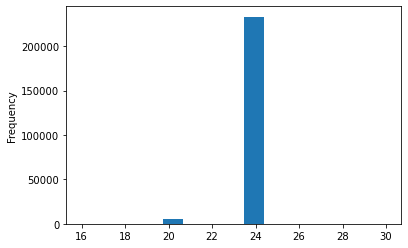

In [29]:
reads_table['barcode_length'].plot.hist(range=(16,30), bins=15)

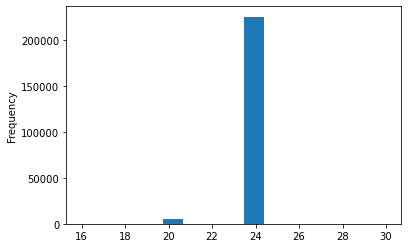

In [30]:
reads_table[reads_table['sanity']==True]['barcode_length'].plot.hist(range=(16,30), bins=15)

From here on, restrict the analysis to reads with `sanity == True`.

In [31]:
good_reads = reads_table[reads_table['sanity']==True][["forward_primer","reverse_primer","R1_barcode"]]
good_reads.columns=(["forward_primer","reverse_primer","barcode"])
good_reads["count"]=1
good_reads

,forward_primer,reverse_primer,barcode,count
0,oVK037,oVK048,GTGTGTGTCACTGTCTCTGACAGA,1
1,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,1
2,oVK033,oVK043,GACTGTGTCAGTGAGAGTGACTCT,1
3,oVK033,oVK048,GTCAGTGAGACTCTCTCAGAGTGT,1
4,oVK031,oVK040,GTCACTGTGTGTCTGACTCTGAGT,1
...,...,...,...,...
242631,oVK025,oVK043,CTGAGTGTCAGTCACTCT,1
242632,oVK031,oVK039,GTGTGTGAGTGACAGTGTGTCTGT,1
242633,oVK033,oVK039,CTGTCTGAGAGACAGACTGTCTGA,1
242634,oVK036,oVK044,GAGTCTCTGTCAGAGTCAGTGTCT,1


In [32]:
counts_table = good_reads.groupby(by=["forward_primer","reverse_primer","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","barcode","count"]
counts_table

,forward_primer,reverse_primer,barcode,count
32,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456
84,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141
1,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106
76,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99
59,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82
...,...,...,...,...
8405,oVK037,oVK048,GTGTCTGACTGACTGA,1
8406,oVK037,oVK048,GTGTCTGACTGTCACTGTGAGTCT,1
8410,oVK037,oVK048,GTGTGTCTCAGAGAGTGTCTGACA,1
8415,oVK037,oVK048,GTGTGTGTGTGTCTGAGACTCTGA,1


In [33]:
little_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()
little_counts_table

,forward_primer,reverse_primer,barcode,count
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82
...,...,...,...,...
955,oVK037,oVK048,CTGAGACTGACACTGACACAGAGT,48
956,oVK037,oVK048,GTCACACTCACACTCACACACAGT,41
957,oVK037,oVK048,GTGTCTGAGTGACTGAGAGT,38
958,oVK037,oVK048,CAGTGTGTCACTCACTCTGTCTCA,30


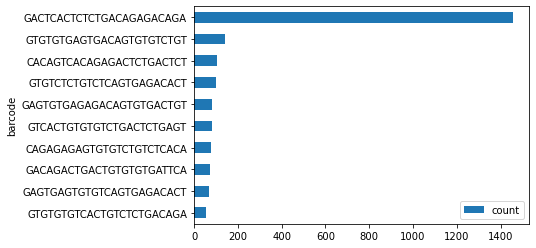

In [34]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK025') & 
    (little_counts_table['reverse_primer']=='oVK026')].sort_values("count").plot.barh(x="barcode",y="count")

[Text(0, 0.5, '')]

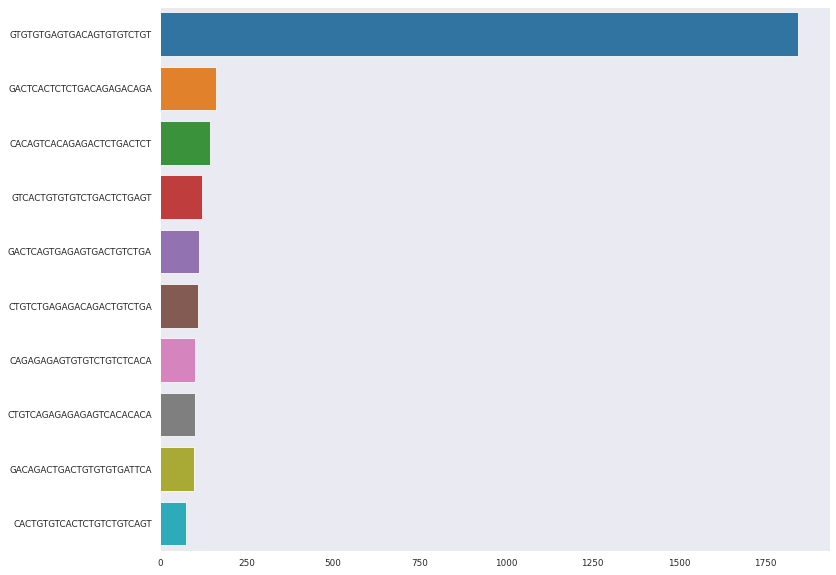

In [35]:
sns.set_style("dark")
sns.set_context("paper")
f, ax = plt.subplots()
f.set_size_inches(12,10)
g = sns.barplot(
        y = "barcode",
        x = "count",
        data=little_counts_table[
            (little_counts_table['forward_primer']=='oVK025') & 
            (little_counts_table['reverse_primer']=='oVK039')].sort_values("count", ascending=False).head(10),
        orient='h', ax=ax
)
g.set(xlabel=None)
g.set(ylabel=None)

Text(0.5, 0.98, 'VK008')

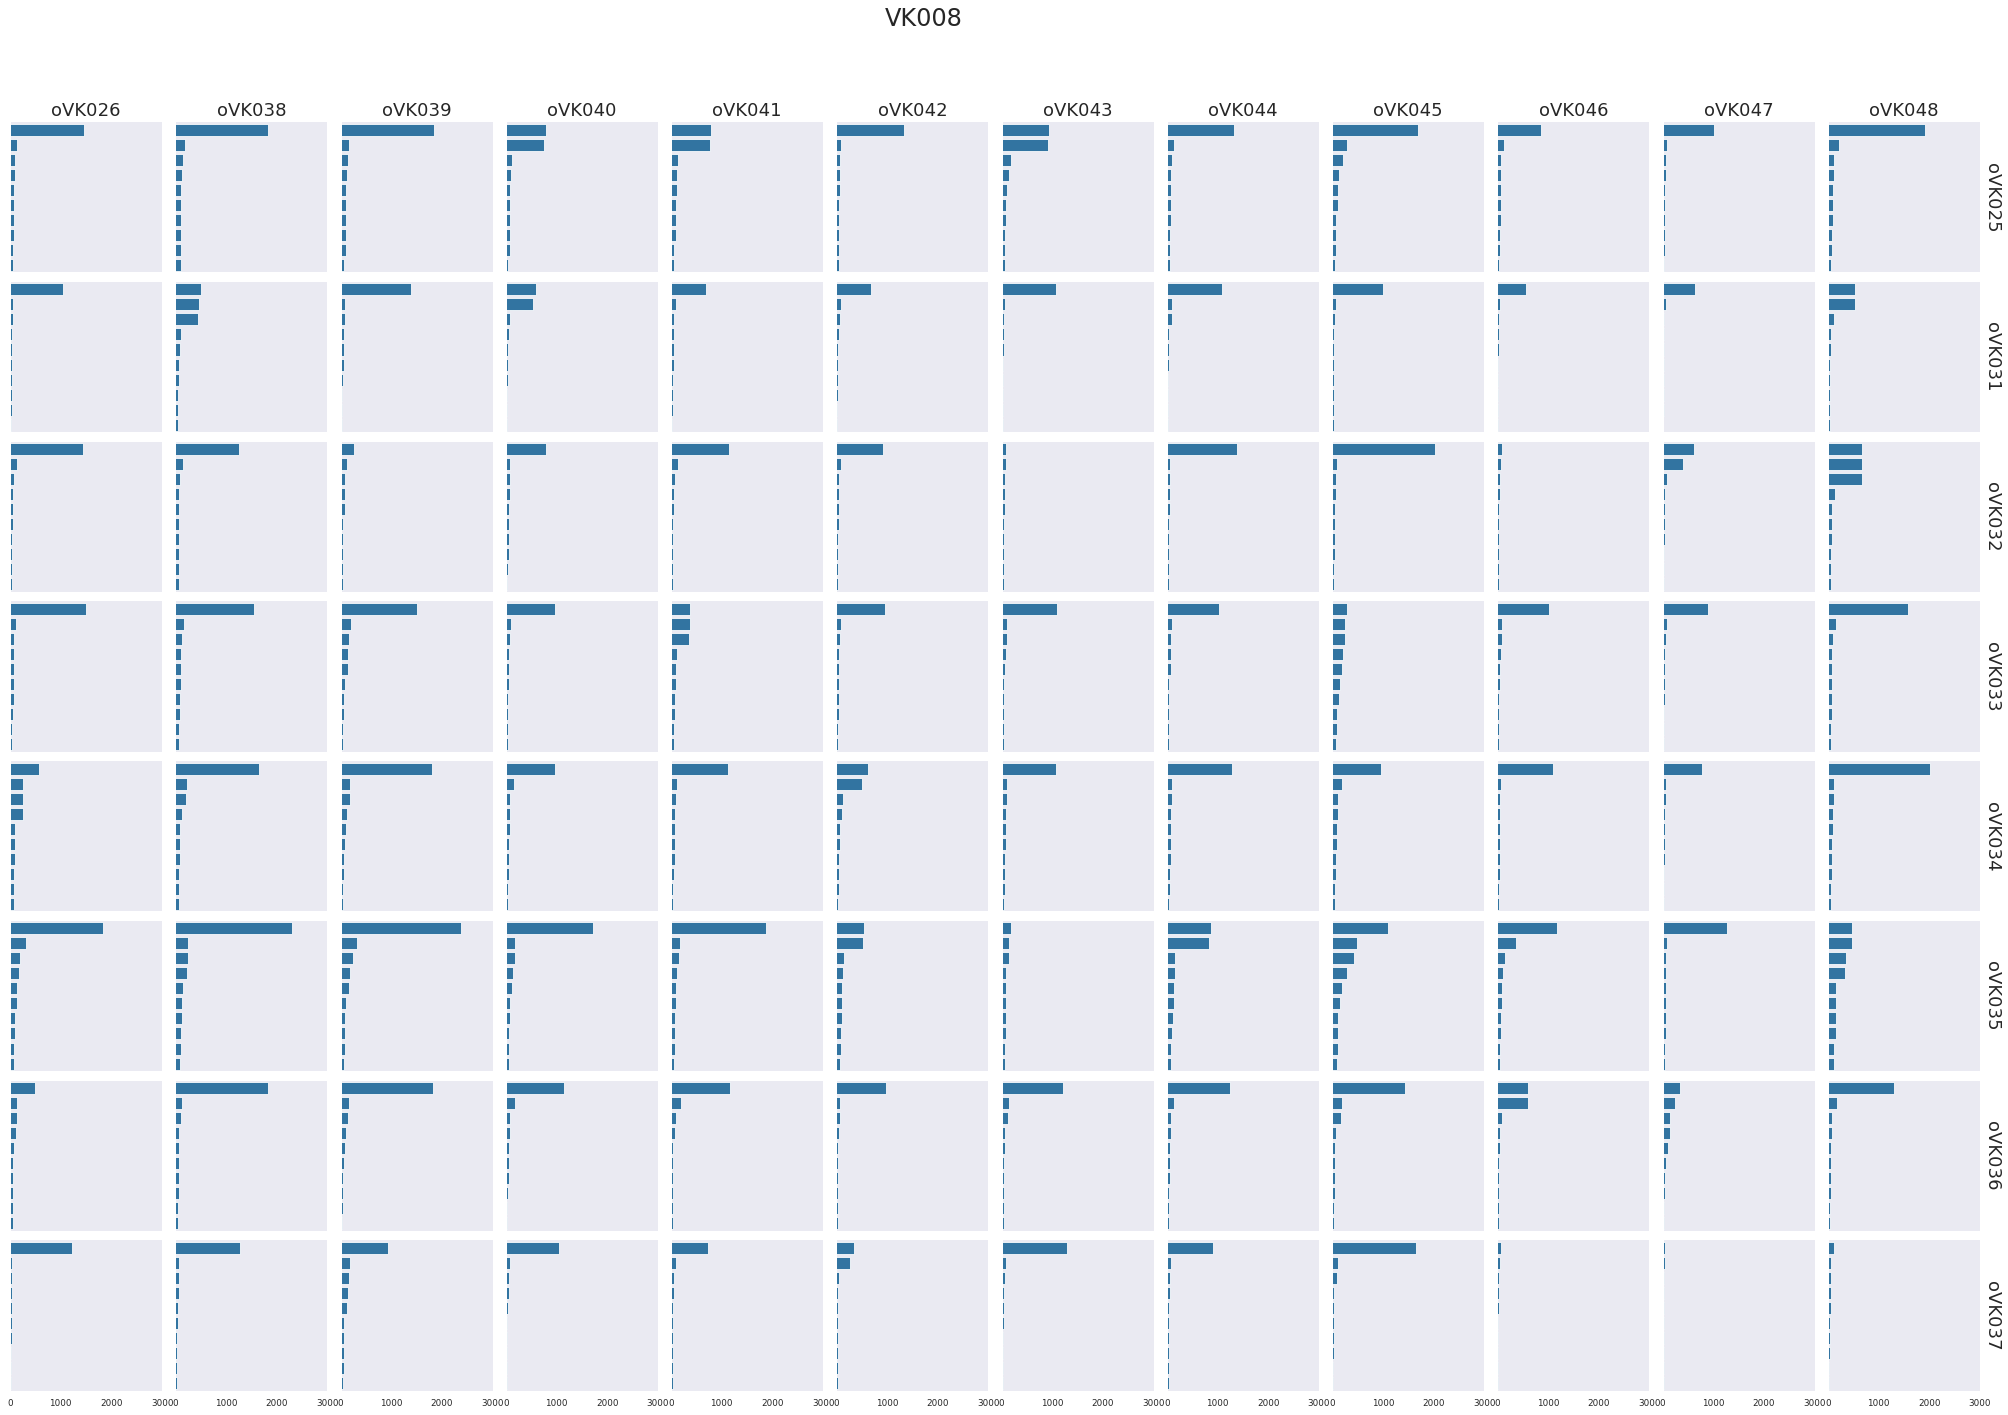

In [36]:
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [37]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK031') & 
    (little_counts_table['reverse_primer']=='oVK044')].sort_values("count", ascending=False)

,forward_primer,reverse_primer,barcode,count
190,oVK031,oVK044,CTGTCTGAGAGACAGACTGTCTGA,1080
191,oVK031,oVK044,GTGTGTGAGTGACAGTGTGTCTGT,103
192,oVK031,oVK044,CACAGTCACAGAGACTCTGACTCT,96
193,oVK031,oVK044,GACTGTGTCAGTGAGAGTGACTCT,41
194,oVK031,oVK044,CAGTGACTGTCAGAGAGTGACAGA,39
195,oVK031,oVK044,CTGTCAGAGAGAGAGTCACACACA,35
196,oVK031,oVK044,GAGAGAGAGTGACAGTGACTCAGA,30
197,oVK031,oVK044,GAGTGTCTCTCAGACTCTCACACT,28
198,oVK031,oVK044,GACTCAGTGAGAGTGACTGTCTGA,23
199,oVK031,oVK044,GACACTGAGACTGACTCACTGTGA,22


In [38]:
top_5_reads = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(5))).reset_index()
top_5_reads["rank"] = top_5_reads.groupby(by=["forward_primer","reverse_primer"]).rank(method="first", ascending=False).astype(int)
top_5_reads

,forward_primer,reverse_primer,barcode,count,rank
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5
...,...,...,...,...,...
475,oVK037,oVK048,GTCACTGTGTGTCTGACTCTGAGT,119,1
476,oVK037,oVK048,GTGTGTGTCACTGTCTCTGACAGA,59,2
477,oVK037,oVK048,CTGTGTGTGTCTGAGTCTGTGTGA,56,3
478,oVK037,oVK048,GAGAGTCAGAGTCTGACTGACTGA,55,4


In [39]:
top_5_reads.to_excel('top_5_barcodes.xlsx')

#### Compute the total number of reads, and annotate the plots.

In [40]:
total_reads = good_reads.groupby(by=["forward_primer","reverse_primer"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer'], ascending=[True,True])
total_reads.columns=["forward_primer","reverse_primer","count"]
total_reads

,forward_primer,reverse_primer,count
0,oVK025,oVK026,2777
1,oVK025,oVK038,3854
2,oVK025,oVK039,3456
3,oVK025,oVK040,2554
4,oVK025,oVK041,2883
...,...,...,...
91,oVK037,oVK044,1623
92,oVK037,oVK045,2518
93,oVK037,oVK046,531
94,oVK037,oVK047,473


In [41]:
total_reads[(total_reads['forward_primer']=='oVK025') & (total_reads['reverse_primer']=='oVK041')].iloc[0]['count']

2883

Text(0.5, 0.98, 'VK008')

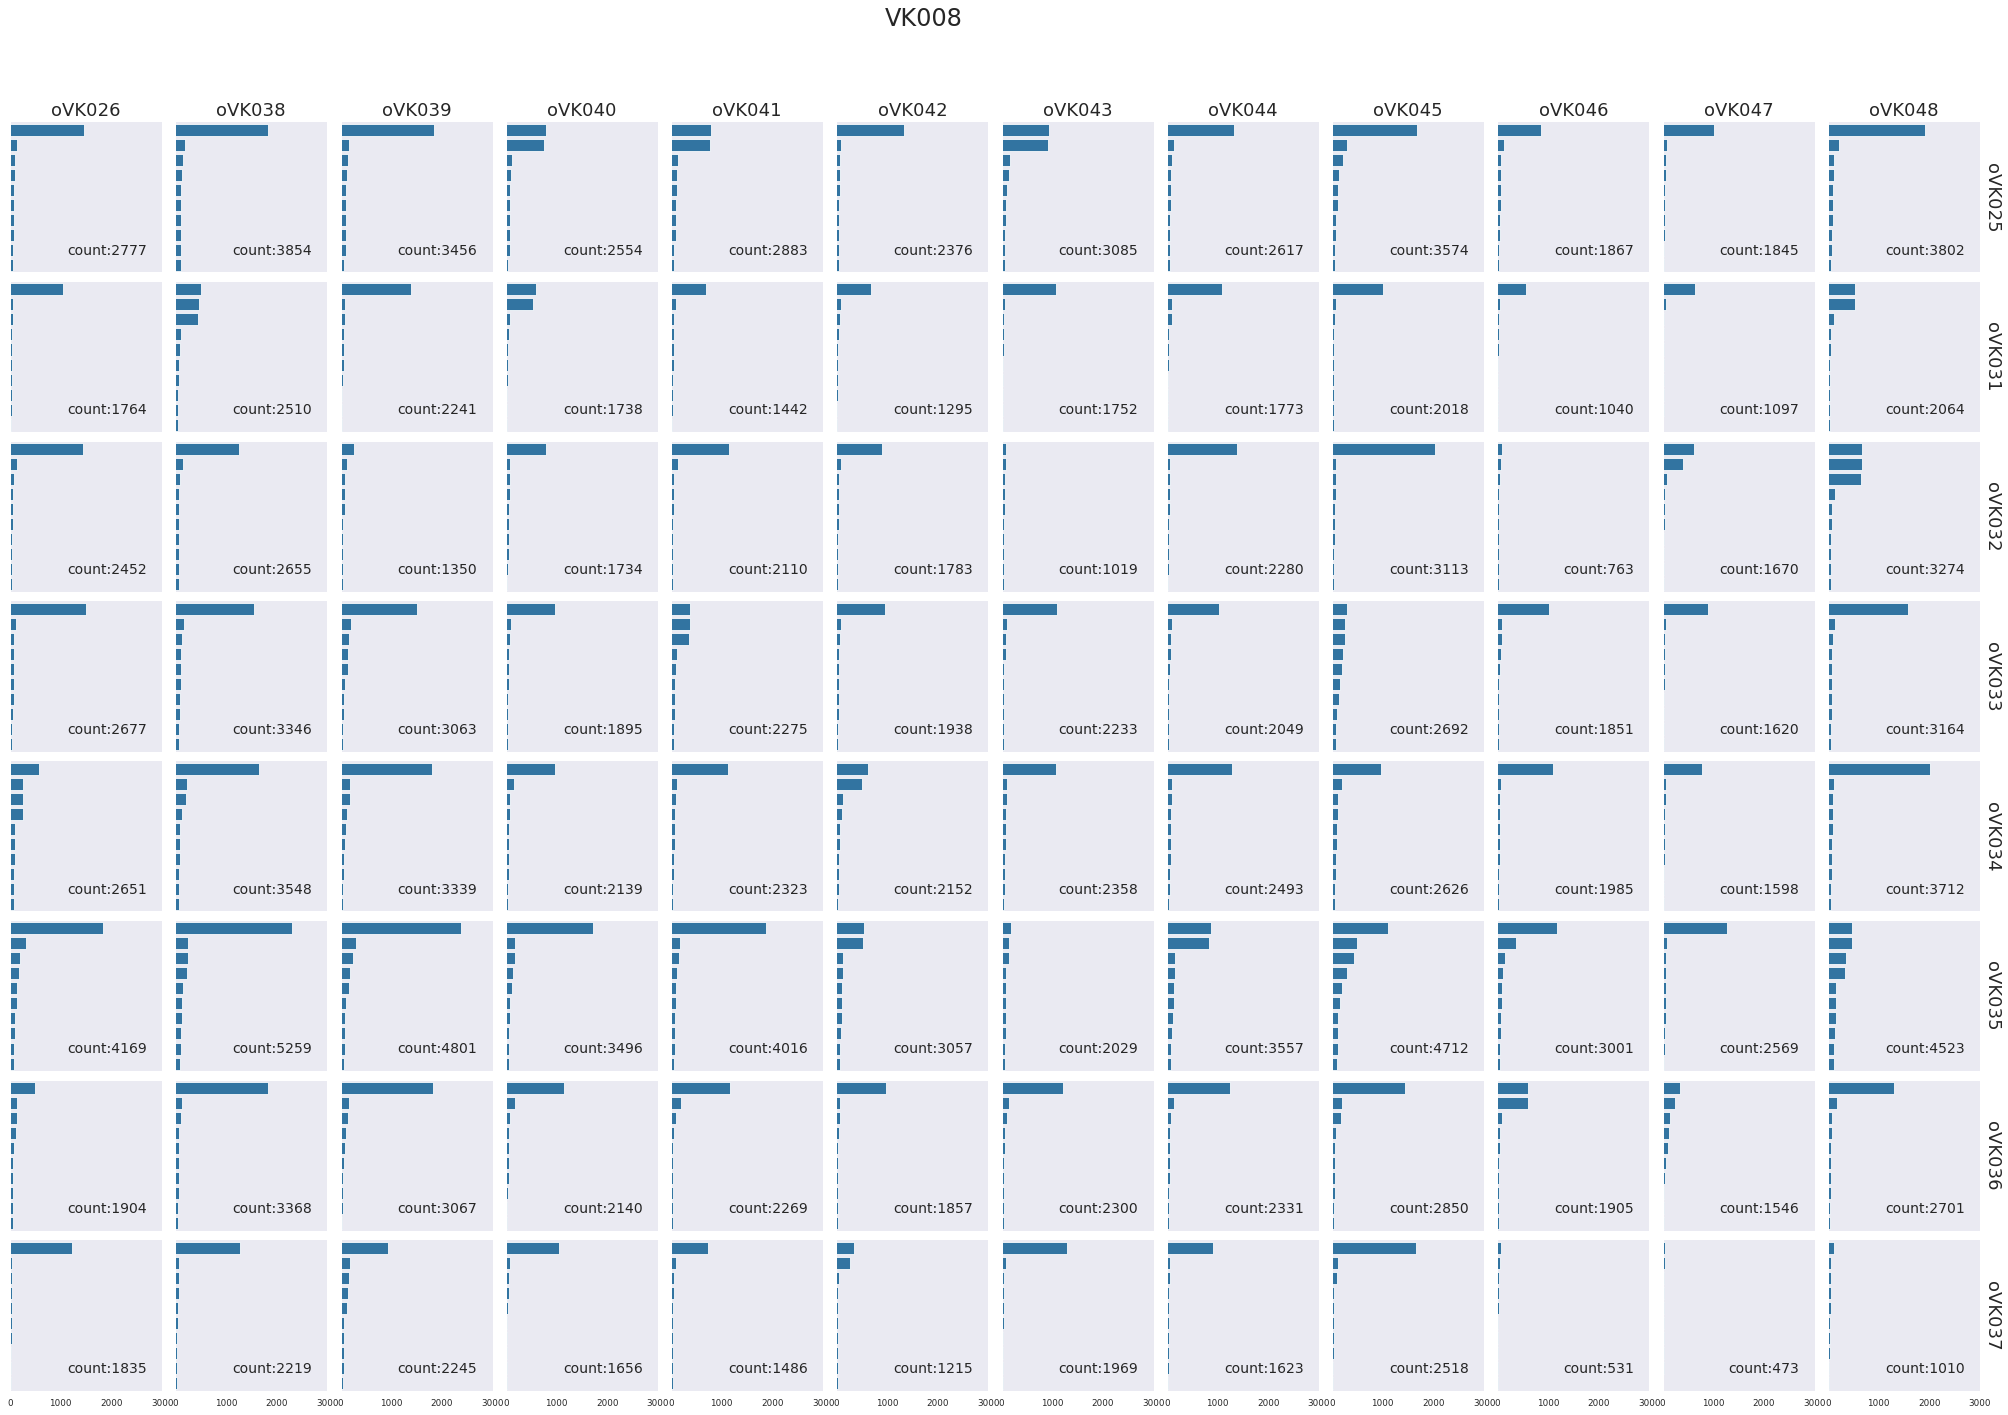

In [59]:
def annotate(data, **kws):
    f = data.iloc[0]['forward_primer']
    r = data.iloc[0]['reverse_primer']
    n = total_reads[(total_reads['forward_primer'] == f) & (total_reads['reverse_primer'] == r)].iloc[0]['count']
    ax = plt.gca()
    ax.text(.9, .1, f"count:{n}", fontsize=14, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="barcode", orient='h')
g2.map_dataframe(annotate)
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

In [43]:
g2.savefig("histograms.png")

## Filter for Clones with 1 or 2 Dominant Barcodes

In [88]:
with open(samples_file, 'r') as f:
    samples_table = f.read()
    print(samples_table)

	oVK026	oVK38	oVK39	oVK40	oVK41	oVK42	oVK43	oVK44	oVK45	oVK46	oVK47	oVK48
oVK025	1514	1515	1516	1517	1518	1519	1520	1521	1522	1523	1524	1525
oVK031	1526	1527	1528	1529	1530	1531	1532	1533	1534	1535	1540	1541
oVK032	1542	1543	1544	1545	1546	1547	1548	1549	1550	1617	1578	1579
oVK033	1580	1581	1582	1583	1584	1585	1586	1587	1588	1618	1619	1634
oVK034	1635	1589	1590	1591	1592	1593	1594	1595	1596	1597	1598	1599
oVK035	1600	1601	1602	1603	1604	1605	1606	1607	1609	1610	1611	1612
oVK036	1613	1614	1620	1621	1622	1623	1624	1625	1626	1627	1628	1637
oVK037	1638	1639	1640	1642	1644	1645	245	289	431	water		



In [89]:
import csv, re

primer_name_regex = re.compile(r"(oVK)(\d{1,3})")

def pad_primer(s):
    m = primer_name_regex.match(s)
    return m.group(1) + m.group(2).rjust(3, '0')

with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]

In [79]:
sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [83]:
top_5_reads['sample']=top_5_reads.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

In [84]:
top_5_reads

,forward_primer,reverse_primer,barcode,count,rank,sample
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1,1514
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2,1514
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3,1514
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4,1514
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5,1514
...,...,...,...,...,...,...
475,oVK037,oVK048,GTCACTGTGTGTCTGACTCTGAGT,119,1,
476,oVK037,oVK048,GTGTGTGTCACTGTCTCTGACAGA,59,2,
477,oVK037,oVK048,CTGTGTGTGTCTGAGTCTGTGTGA,56,3,
478,oVK037,oVK048,GAGAGTCAGAGTCTGACTGACTGA,55,4,


In [93]:
top_5_reads[top_5_reads['sample'] == 'water']

,forward_primer,reverse_primer,barcode,count,rank,sample
465,oVK037,oVK046,GTCACTGTGTGTCTGACTCTGAGT,78,1,water
466,oVK037,oVK046,GTCAGACTCTGACACTGAGACACA,48,2,water
467,oVK037,oVK046,GAGTGTCAGTCTGTGAGTGAGACT,39,3,water
468,oVK037,oVK046,GACTCAGTGAGAGTGACTGTCTGA,38,4,water
469,oVK037,oVK046,CTGTGTGTGTCTGAGTCTGTGTGA,31,5,water


In [96]:
water_count = top_5_reads[top_5_reads['sample'] == 'water']['count'].max()
water_count

78

In [97]:
top_5_reads[top_5_reads['count'] > water_count]

,forward_primer,reverse_primer,barcode,count,rank,sample
0,oVK025,oVK026,GACTCACTCTCTGACAGAGACAGA,1456,1,1514
1,oVK025,oVK026,GTGTGTGAGTGACAGTGTGTCTGT,141,2,1514
2,oVK025,oVK026,CACAGTCACAGAGACTCTGACTCT,106,3,1514
3,oVK025,oVK026,GTGTCTCTGTCTCAGTGAGACACT,99,4,1514
4,oVK025,oVK026,GAGTGTGAGAGACAGTGTGACTGT,82,5,1514
...,...,...,...,...,...,...
455,oVK037,oVK044,GAGAGAGAGTGACAGTGACTCAGA,920,1,289
460,oVK037,oVK045,CTGTGTGTGTCTGAGTCTGTGTGA,1659,1,431
461,oVK037,oVK045,GTCACTGTGTGTCTGACTCTGAGT,111,2,431
462,oVK037,oVK045,GTGTGTGAGTGACAGTGTGTCTGT,101,3,431


In [100]:
counts_table['sample'] = counts_table.apply(
    lambda row: sample_dict[ row['forward_primer'] ][ row['reverse_primer'] ],
    axis=1
)

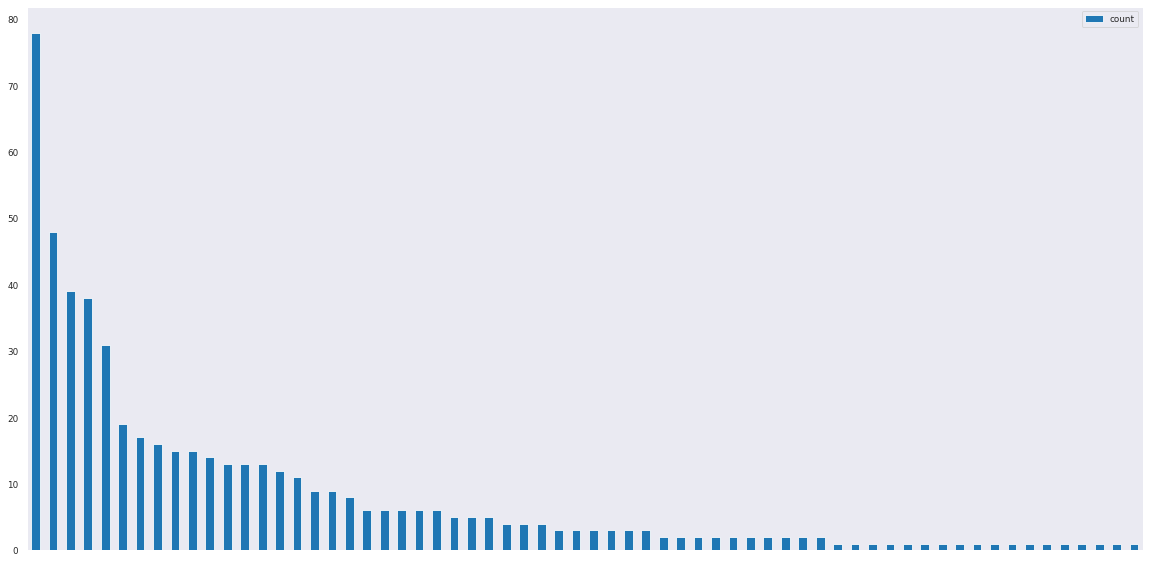

In [113]:
counts_table[counts_table['sample']=='water'].sort_values("count", ascending=False).plot.bar(y="count", xticks=[], figsize=(20,10))

In [124]:
top_5_reads.groupby(['forward_primer','reverse_primer'])['count'].sum()

forward_primer  reverse_primer
oVK025          oVK026            1884
                oVK038            2436
                oVK039            2384
                oVK040            1852
                oVK041            1939
                                  ... 
oVK037          oVK044            1152
                oVK045            1952
                oVK046             234
                oVK047             173
                oVK048             343
Name: count, Length: 96, dtype: int64

In [129]:
y = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10)))
y['cumsum'] = y.groupby(level=[0,1])['count'].transform('cumsum')
y['running_percent'] = y['cumsum'] / y.groupby(level=[0,1])['count'].transform('sum')
y

barcode  count sample  cumsum  \
forward_primer reverse_primer                                                   
oVK025         oVK026          GACTCACTCTCTGACAGAGACAGA   1456   1514    1456   
               oVK026          GTGTGTGAGTGACAGTGTGTCTGT    141   1514    1597   
               oVK026          CACAGTCACAGAGACTCTGACTCT    106   1514    1703   
               oVK026          GTGTCTCTGTCTCAGTGAGACACT     99   1514    1802   
               oVK026          GAGTGTGAGAGACAGTGTGACTGT     82   1514    1884   
...                                                 ...    ...    ...     ...   
oVK037         oVK048          CTGAGACTGACACTGACACAGAGT     48            391   
               oVK048          GTCACACTCACACTCACACACAGT     41            432   
               oVK048              GTGTCTGAGTGACTGAGAGT     38            470   
               oVK048          CAGTGTGTCACTCACTCTGTCTCA     30            500   
               oVK048              CAGTGAGTGACTGAGACTGA     28            528   

                               running_percent  
forward_primer reverse_primer                   
oVK025         oVK026                 0.649710  
               oVK026                 0.712628  
               oVK026                 0.759929  
               oVK026                 0.804105  
               oVK026                 0.840696  
...                                        ...  
oVK037         oVK048                 0.740530  
               oVK048                 0.818182  
               oVK048                 0.890152  
               oVK048                 0.946970  
               oVK048                 1.000000  

[960 rows x 5 columns]

Text(0.5, 0.98, 'VK008')

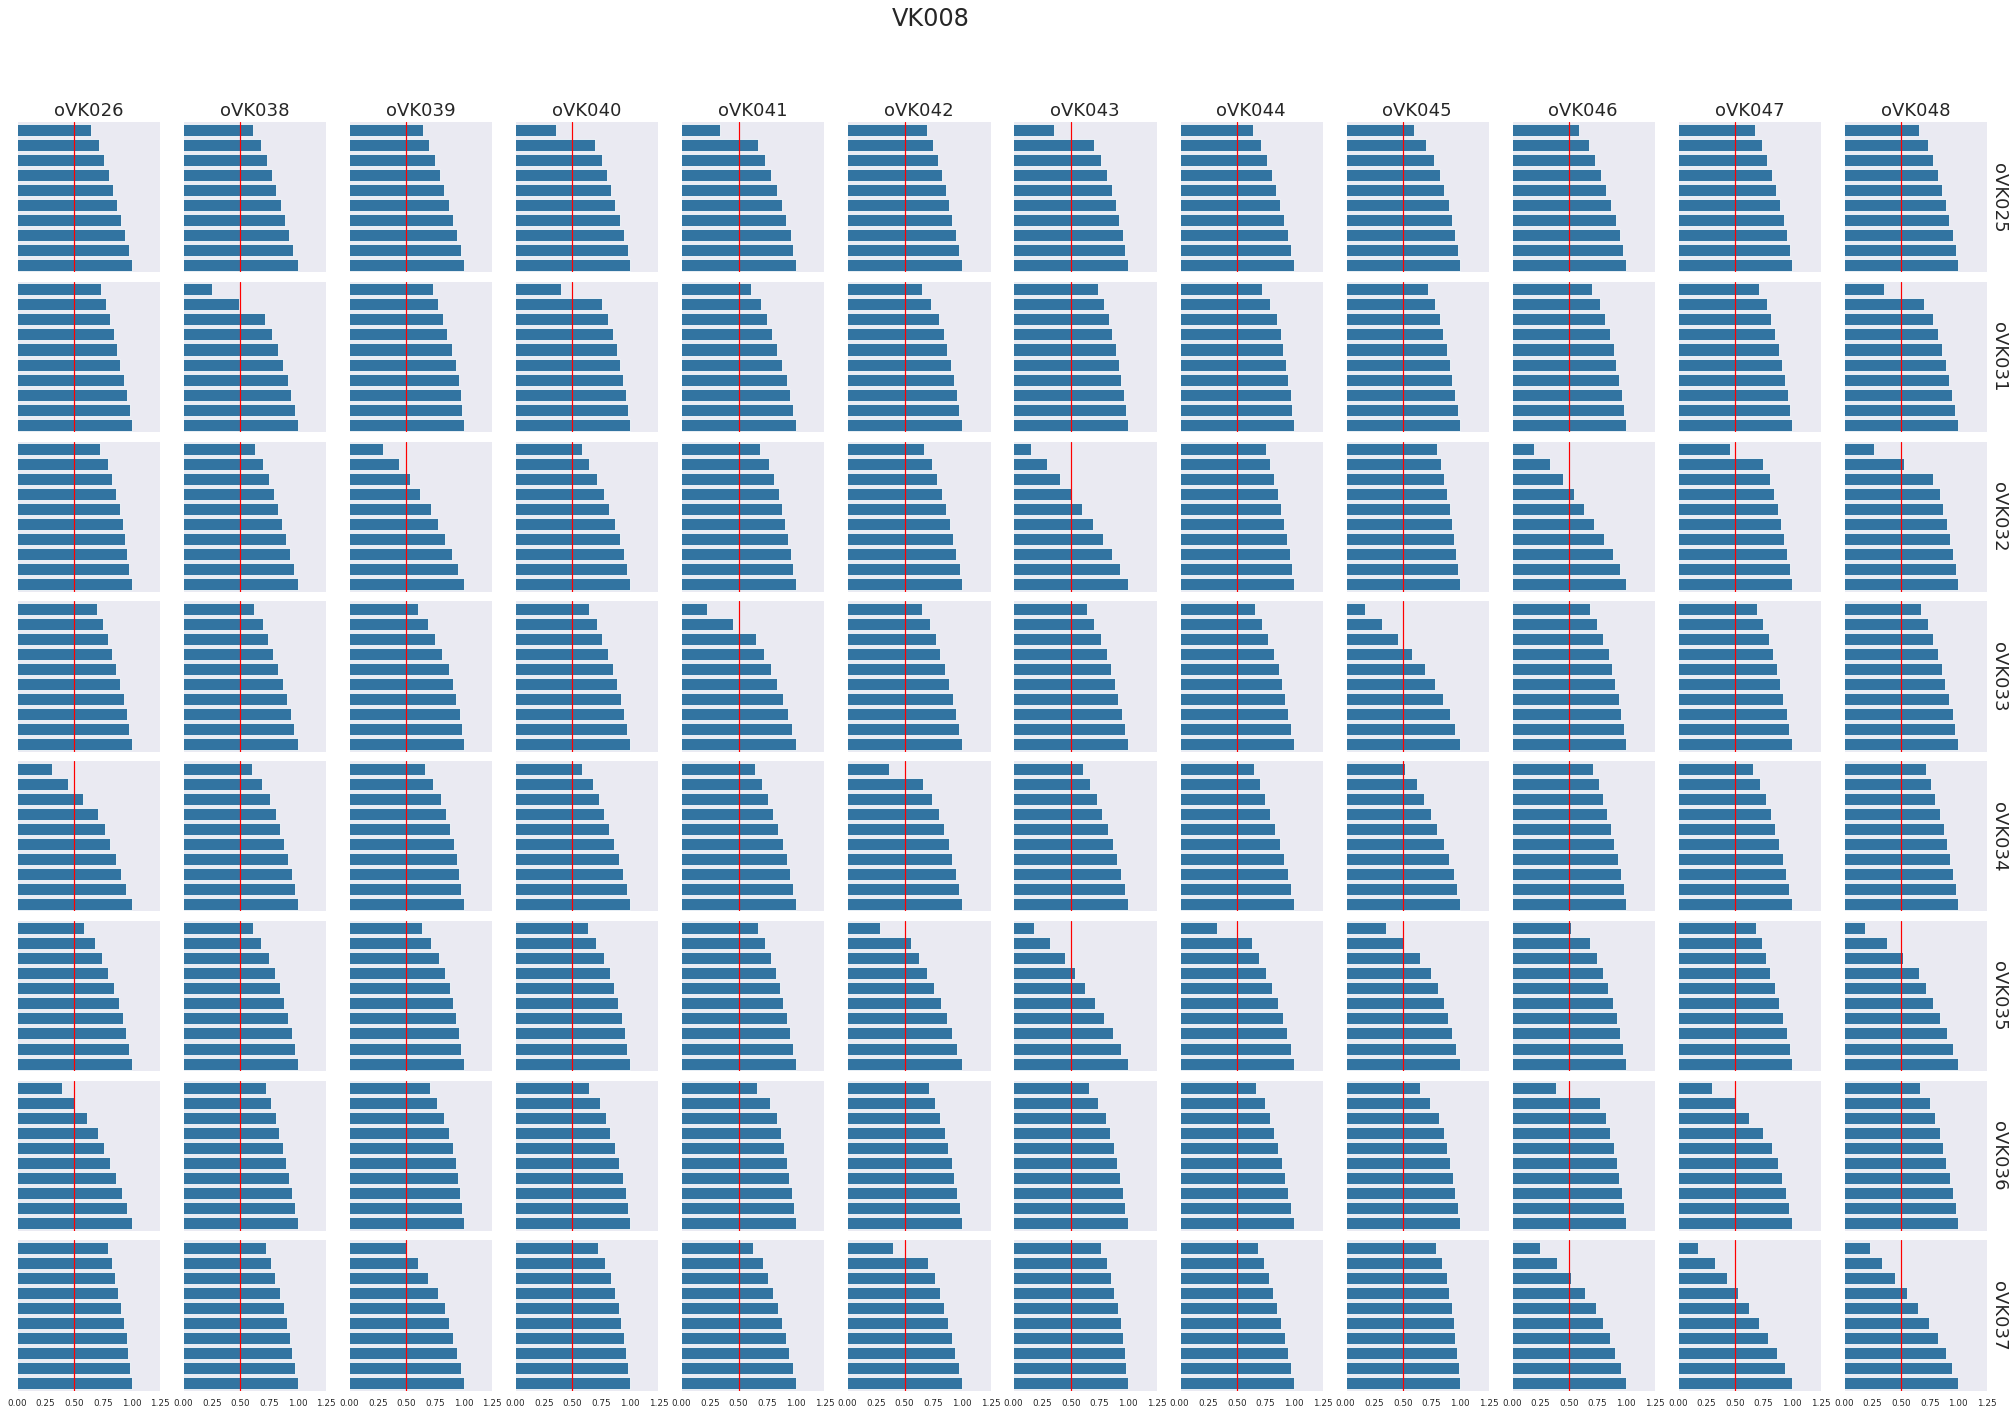

In [134]:
z = y.reset_index()
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(z, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="running_percent",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

for ax in g2.axes.flat:
    ax.axvline(x=0.5, color='r', linestyle='-')

plt.subplots_adjust(top=0.9)
g2.fig.suptitle(experiment, fontsize=24)

### Find overlapping barcodes

In [45]:
fwd = "oVK025"
rev = "oVK038"
bc = counts_table[(counts_table['forward_primer']==fwd) & (counts_table['reverse_primer']==rev)].nlargest(1,"count")["barcode"].iloc[0]
bc

'CTAAGTGAGTGACAGAGTGTCTCA'

In [46]:
counts_table[counts_table['barcode'] == bc]

,forward_primer,reverse_primer,barcode,count
8,oVK025,oVK026,CTAAGTGAGTGACAGAGTGTCTCA,4
102,oVK025,oVK038,CTAAGTGAGTGACAGAGTGTCTCA,243
185,oVK025,oVK039,CTAAGTGAGTGACAGAGTGTCTCA,8
286,oVK025,oVK040,CTAAGTGAGTGACAGAGTGTCTCA,1
340,oVK025,oVK041,CTAAGTGAGTGACAGAGTGTCTCA,4
397,oVK025,oVK042,CTAAGTGAGTGACAGAGTGTCTCA,1
443,oVK025,oVK043,CTAAGTGAGTGACAGAGTGTCTCA,2
494,oVK025,oVK044,CTAAGTGAGTGACAGAGTGTCTCA,4
559,oVK025,oVK045,CTAAGTGAGTGACAGAGTGTCTCA,2
629,oVK025,oVK046,CTAAGTGAGTGACAGAGTGTCTCA,9


## Experimental

/opt/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


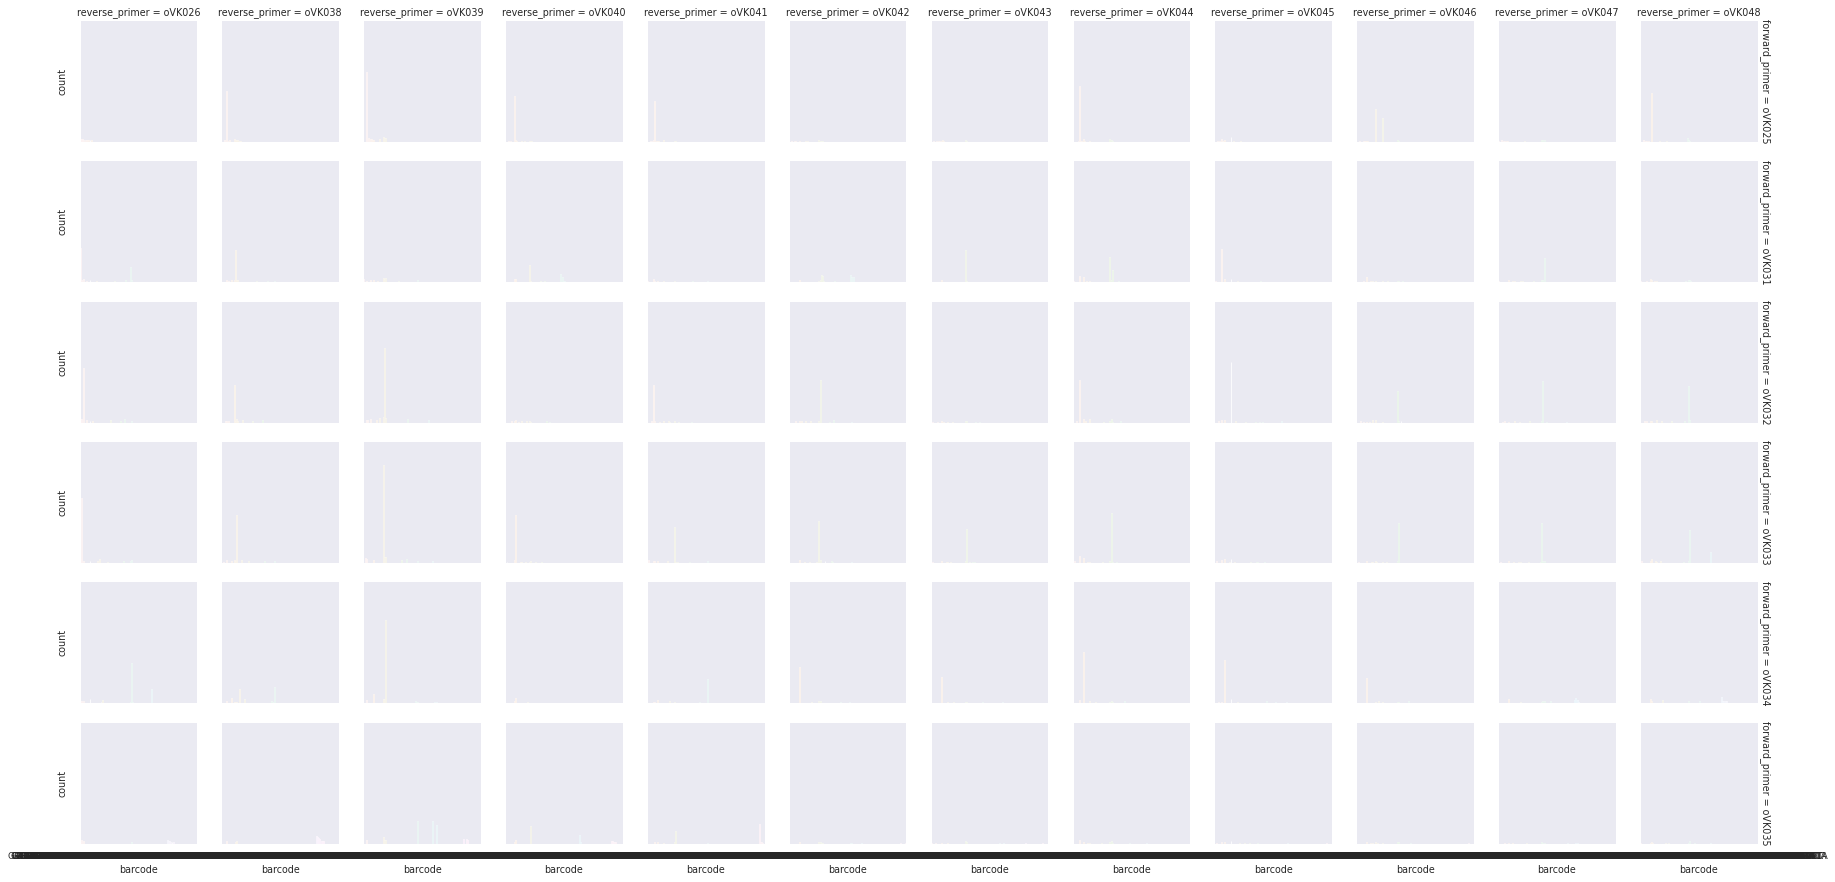

In [100]:
g3 = sns.catplot(
    x="barcode", 
    y="count",
    col="reverse_primer",
    row="forward_primer",
    data=little_counts_table, 
    kind="bar",
    height=2, aspect=1,
    margin_titles=True
)
g3.set_xticklabels(None)
g3.set_yticklabels(None)
g3.set_xlabels(None)
g3.set_ylabels(None)

In [121]:
perl_counts_file = "VK001.barcode_pair_sequence.count.txt"
perl_counts = pd.read_table(perl_counts_file, sep='\t', names=["primer1","primer2","sequence","count"])
perl_counts

,primer1,primer2,sequence,count
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545
...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1


In [129]:
perl_counts['direction1'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer1'][2:] ]['direction'],
    axis = 1
)

perl_counts['direction2'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer2'][2:] ]['direction'],
    axis = 1
)

perl_counts

,primer1,primer2,sequence,count,direction1,direction2
0,F_oVK033,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,F,R
1,F_oVK034,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,F,R
2,F_oVK032,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,F,R
3,F_oVK025,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,F,R
4,F_oVK031,R_oVK039,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,F,R
...,...,...,...,...,...,...
8176,F_oVK037,R_oVK045,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8177,F_oVK037,R_oVK046,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8178,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R
8179,F_oVK037,R_oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,F,R


In [142]:
perl_counts['forward_primer'] = perl_counts.apply(
    lambda row: primer_lookup[ row['primer2'][2:] ]['direction'],
    axis = 1
)

perl_counts['forward_primer'] = perl_counts['primer1'].where(
    perl_counts['direction1'] == 'F',
    perl_counts['primer2']
)

perl_counts['reverse_primer'] = perl_counts['primer1'].where(
    perl_counts['direction1'] == 'R',
    perl_counts['primer2']
)

perl_counts['forward_primer'] = perl_counts['forward_primer'].apply(lambda s: s[2:])
perl_counts['reverse_primer'] = perl_counts['reverse_primer'].apply(lambda s: s[2:])

perl_counts = perl_counts.drop(['primer1','primer2','direction1','direction2'], axis=1)

perl_counts

,sequence,count,forward_primer,reverse_primer
0,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2124,oVK033,oVK039
1,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1788,oVK034,oVK039
2,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1600,oVK032,oVK039
3,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1599,oVK025,oVK039
4,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1545,oVK031,oVK039
...,...,...,...,...
8176,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK045
8177,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK046
8178,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK047
8179,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK037,oVK047


In [147]:
little_perl_counts = perl_counts.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()
little_perl_counts

,forward_primer,reverse_primer,sequence,count
0,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1448
1,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,160
2,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,73
3,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70
4,oVK025,oVK026,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,70
...,...,...,...,...
757,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,2
758,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
759,oVK037,oVK047,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1
760,oVK037,oVK048,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,4


[Text(0, 0.5, '')]

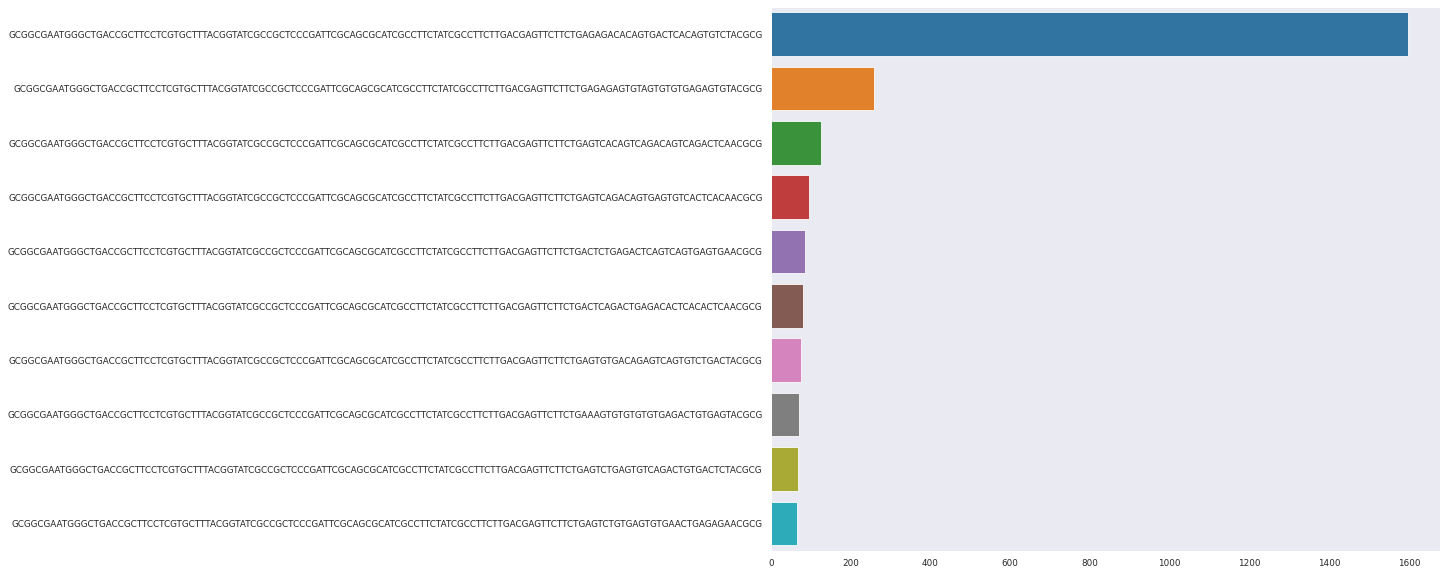

In [152]:
sns.set_style("dark")
sns.set_context("paper")
f, ax = plt.subplots()
f.set_size_inches(12,10)
g = sns.barplot(
        y = "sequence",
        x = "count",
        data=little_perl_counts[
            (little_perl_counts['forward_primer']=='oVK025') & 
            (little_perl_counts['reverse_primer']=='oVK039')].sort_values("count", ascending=False).head(10),
        orient='h', ax=ax
)
g.set(xlabel=None)
g.set(ylabel=None)

Text(0.5, 0.98, 'VK001 - perl output')

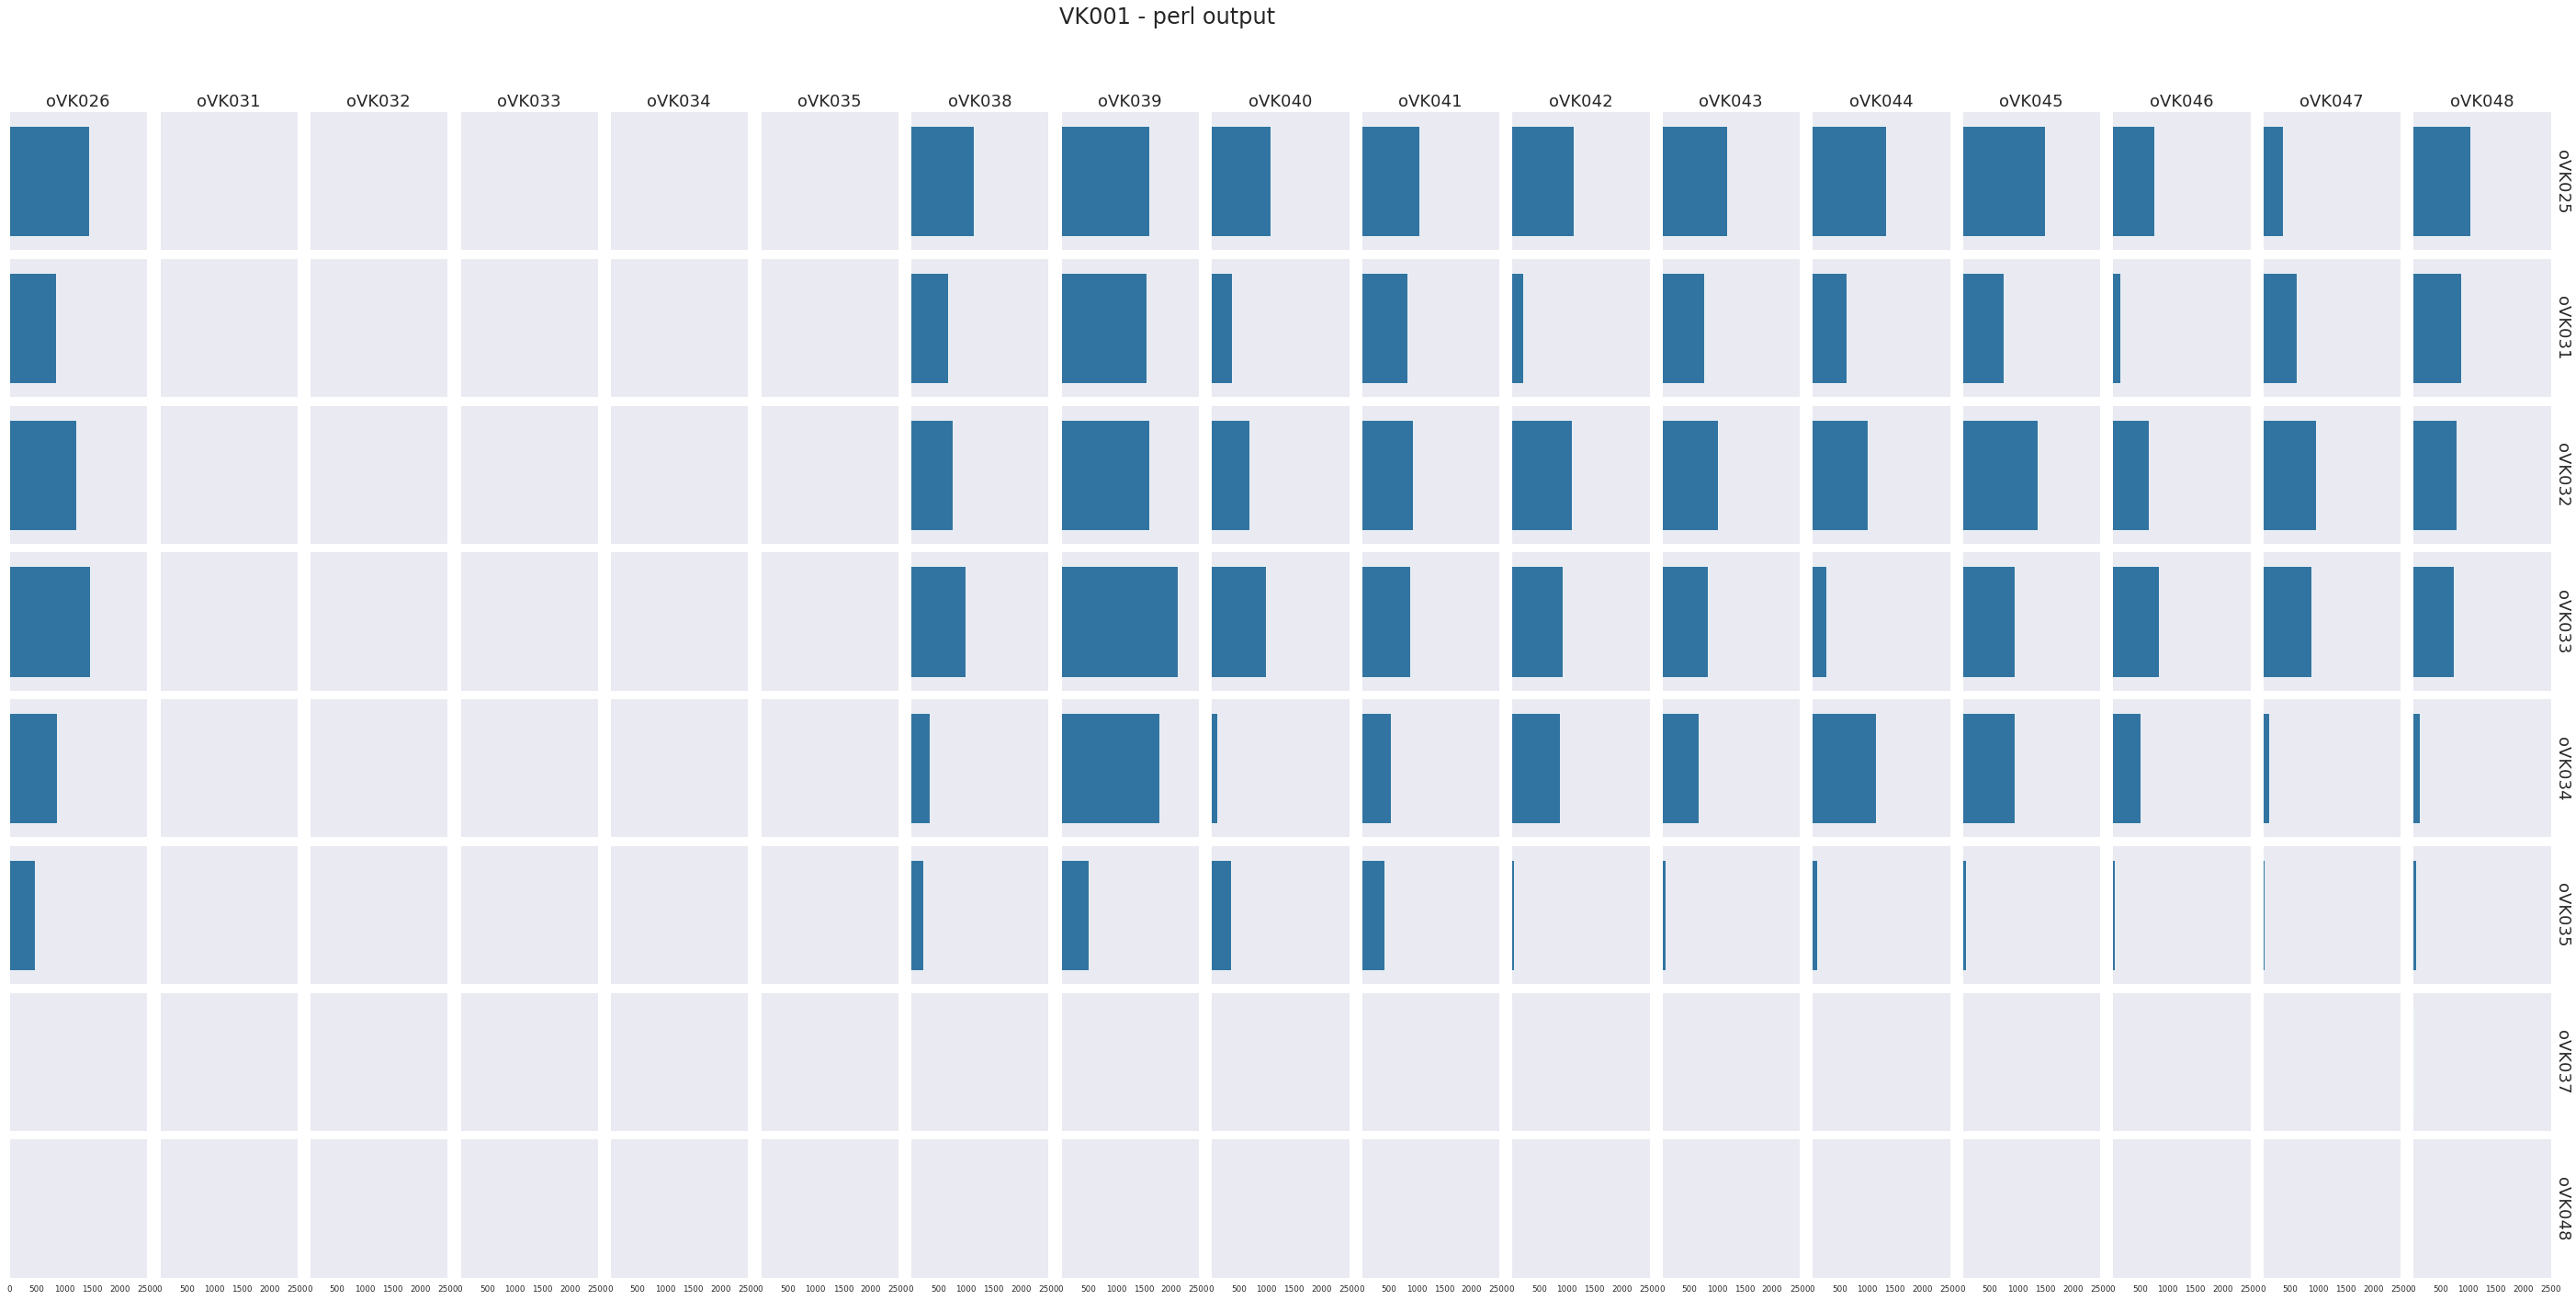

In [148]:
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_perl_counts, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="sequence", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle("VK001 - perl output", fontsize=24)

In [145]:
perl_counts[
    (perl_counts['forward_primer']=='oVK031') & 
    (perl_counts['reverse_primer']=='oVK044')].sort_values("count", ascending=False)

,sequence,count,forward_primer,reverse_primer
47,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,619,oVK031,oVK044
61,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,349,oVK031,oVK044
75,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,166,oVK031,oVK044
93,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,124,oVK031,oVK044
218,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,61,oVK031,oVK044
...,...,...,...,...
5690,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5689,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5688,GCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGC...,1,oVK031,oVK044
5687,AGGGAGGCAGCAGCGACAGGCATCCATGGGTGCCATCCTGGGGTGG...,1,oVK031,oVK044


# A Bunch of Stuff I Don't Want to Get Rid of Yet

In [ ]:
def PrintSeqSingleRow(n, direction, table):
    read = table.iloc[n]
    if direction == 'R1':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        sequence = read['R1_sequence']
    elif direction == 'R2':
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R2_barcode_loc']
            ]
        sequence = read['R2_sequence']
    else:
        return ""
    # print(intervals)
    highlights = ColorSeq(sequence, intervals)
    return highlights

In [ ]:
for i in range(25):
    print( "{0:4d} {1[R1_fwd_direction]} {1[R1_rc_direction]} {2:4d} {3:4d}".format(
        i, reads_table.iloc[i], len(reads_table.iloc[i]['R1_sequence']), len(reads_table.iloc[i]['R2_sequence'])) )

In [ ]:
def PrintSeqMultiRow(n, table):
    read = table.iloc[n]
    highlights = ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
            [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'], read['R1_pre_loc'] + len(reference_sequence_pre) ],
            [read['R1_post_loc'], read['R1_post_loc'] + len(reference_sequence_post) ]
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'] + len(reference_sequence_pre), read['R1_post_loc']]
        ]
    )
    return highlights

In [ ]:
h=PrintSeqMultiRow(1, reads_table)
print(h)

In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', reads_table.iloc[i]['sequence'])
    print()

In [ ]:
from colored import bg, fg, attr
from itertools import chain

def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

def InsertCodes(s, code_tuples, default_code=bg(0)+fg(15)):
    code_tuples.sort()
    indices = [0] + [i[0] for i in code_tuples] + [len(s)]
    codes = [i[1] for i in code_tuples] + [default_code]
    substrings = SplitString(s, indices)
    return default_code + ''.join( chain(*zip(substrings,codes)) )

def DisplayRow(row):
    display_string = row['R1_sequence']
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (row['R1_fwd_primer_loc'], bg('light_gray')),
        (row['R1_fwd_primer_loc']+primer_lookup[ row['R1_fwd_primer'] ]['len'], default_bg),
        # reverse primer
        (row['R1_rc_primer_loc'], bg('light_gray')),
        (row['R1_rc_primer_loc']+primer_lookup[ row['R1_rc_primer'] ]['len'], default_bg),
        # pre-flanking sequence
        (row['R1_pre_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (row['R1_post_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if row['R1_fwd_direction']=='F':
        # barcode
        color_codes += [
            (row['R1_pre_loc']+len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (row['R1_post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (row['R1_post_loc']+len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (row['R1_pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# following not done: need to take out the R1 and pass in 'fwd_primer_loc', etc
def DisplaySeq(seq, locations):
    display_string = seq
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (locations['fwd_primer_loc'], bg('dark_gray')),
        (locations['fwd_primer_loc'] + locations['fwd_primer_len'], default_bg),
        # reverse primer
        (locations['rc_primer_loc'], bg('dark_gray')),
        (locations['rc_primer_loc'] + locations['rc_primer_len'], default_bg),
        # pre-flanking sequence
        (locations['pre_loc'], attr('bold')),
        (locations['pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (locations['post_loc'], attr('bold')),
        (locations['post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if locations['direction']=='F':
        # barcode
        color_codes += [
            (locations['pre_loc'] + len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (locations['post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (locations['post_loc'] + len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (locations['pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# Need to reverse the direction for 'R' reads
def DisplayRowWithDirection(row, read):
    # row is a row of reads_table
    # read = 1 or 2
    if read == 1:
        readchar = 'R1'
    else:
        readchar = 'R2'
    if row[readchar + '_fwd_direction'] == 'F':
        direction = 'F'
        seq = row[readchar + '_sequence']
        postrx = lambda x: x
    else:
        direction = 'R'
        seq = row[readchar + '_sequence'][::-1]
        l = len(seq)
        postrx = lambda x: l - 1 - x # not working
    
    locations = {
        'fwd_primer_loc':postrx( row[readchar + '_fwd_primer_loc'] ),
        'fwd_primer_len':primer_lookup[ row[readchar + '_fwd_primer'] ]['len'],
        'rc_primer_loc':postrx( row[readchar + '_rc_primer_loc'] ),
        'rc_primer_len':primer_lookup[ row[readchar + '_rc_primer'] ]['len'],
        'pre_loc':postrx( row[readchar + '_pre_loc'] ),
        'post_loc':postrx( row[readchar + '_post_loc'] ),
        'fwd_primer':row[readchar + '_fwd_primer'],
        'rc_primer':row[readchar + '_rc_primer']
    }
    locations['direction']=direction,
    
    return DisplaySeq(seq, locations)

In [ ]:
print(
    DisplayRow( reads_table.iloc[1] )
)
print(
    DisplayRow( reads_table.iloc[2] )
)
print(
    DisplayRow( reads_table.iloc[3] )
)

In [ ]:
print(
    DisplayRowWithDirection( reads_table.iloc[1], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[1], 2 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 2 )
)

In [ ]:
with open('reads.txt', 'w') as f:
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 2 ) + '\n\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 2 ) + '\n' )


In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqOriented(i, reads_table) )
    print()